# NFL Fantasy Analysis

Context, I'm playing fantasy football using Yahoo fantasy app.

Here I'm going to try to anazlyse the stats that help the players on my fantasy roster, I may even train a model for them each (which may require a lot more historial data). Some requirements
1. I need to be able to quickly grab the players & defense on my roster as I will have to change players each week
2. The first analysis I need to do is on the stats that get me the most post
  1. First analysis of average fantasy points over these seasons, bench and line
  2. How win vs lose vs draw affects points earned


## Questions
1. It was suggested to me that its better to pickup a QB later as the difference in points between a good and a bad qb isn't as great as the difference between a good RB/WR
2. What factors affect the number of points a player can earn?
3. How can I use statistical techniques to make better decisions for who to draft (or at least confirm the rankings in the yahoo app for myself).



## Fantasy NFL Analysis

First step is to load the data, we will see that I decide to do a bit of good ol' fashioned hypothesis testing here, so I'm bringing in `scipy.stats.ttest_ind` to allow me to use Welch's *t*-test

## The Data

Using 3 datasets downloaded from a random website - not sure where they got it. Contains 3 datasts with data over the last 3 NFL seasons.
- `nfl_pass_rush_receive_raw_data.csv` Raw data of games played by individual players with offensive play stats (passing and rushing)
- `nfl_kicking_raw_data.csv` which lists games played by kickers
- `nfl_dst_raw_data.csv` which lists games played by individual teams, with defensive play statistics

In [2]:
from operator import index
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt

# Loads the datasets
off_stats = pd.read_csv("nfl_pass_rush_receive_raw_data.csv")
kick_stats = pd.read_csv("nfl_kicking_raw_data.csv")
def_stats = pd.read_csv("nfl_dst_raw_data.csv")
nfl_teams = pd.read_csv("nfl_teams.csv")
fan_off_points = pd.read_csv("fan_off_points.csv", index_col= "stat_code")

# Converts relevant date columns in different datasets into datetime format 
off_stats['game_date'] = pd.to_datetime(off_stats['game_date'])



## Offensive Analysis

We are going to start the analysis looking at offensive stats. This came out of me needing a better way to assess who to add to my fantasy roster since I was getting some questionable players and needed to replace them.

Questions: 
1. Is there a difference in points for a win or a lose? 
1. If so, are some players more sensitive to it than others? 
1. Can we test to ensure we're not just experiencing low sample size effects?

If we can show that some players definitely play worse or better when losing, then on days when you expect a players team to win or lose, this can affect new waivers or who to bench/start.

Beginning with some data transformation
1. **Win-Lose-Draw Column** Add a column identifying whether play

### Win-Lose-Draw Column
Add column tracking whether player's team won, lost or drew.

In [3]:
def add_win_lose_col(off_stats):
    """In-place addition of a df column identifying whether the players team won or lost"""
    
    off_stats['player_won'] = off_stats.apply(lambda row: win_lose_draw(row), axis = 1)


# probably overcomplicating things
def win_lose_draw(row):
    """outputs whether the row (which corresponds to a player) with a given side won or lost or drew"""

    if row['team'] == row['home_team']:
        side = 'home'
    else:
        side = 'vis'

    side_score = side + '_score'
    #ensures that if the row is on one side, the otherside is the opposite team
    otherside_score = 'vis_score' if side == 'home' else 'home_score'

    score_difference = row[side_score] - row[otherside_score]
    if  score_difference > 0:
        return "W"
    elif score_difference < 0:
        return "L"
    else:
        return "D"

add_win_lose_col(off_stats)
off_stats[['player', 'player_won', 'game_date']].sample(10)

,player,player_won,game_date
16157,Russell Gage,W,2021-11-07
1768,Melvin Gordon,L,2019-10-06
9536,Donald Parham,L,2020-11-08
15746,Kylen Granson,L,2021-10-31
1544,Trent Sherfield,W,2019-10-06
18941,Byron Pringle,L,2022-01-02
1122,Adam Shaheen,W,2019-09-23
18319,Marquez Valdes-Scantling,W,2021-12-19
9094,Marcus Johnson,W,2020-11-01
16284,Greg Dortch,W,2021-11-07


### Add Current Offensive Fantasy Points

Using a dataset I took from yahoo which specified our leagues rules (`fan_off_points`) I calculate how many fantasy points each player would have earned retroactively.

In [4]:

def add_fantasy_points_off(off_stats, fan_off_points):
    """in-place calculates a new column for input offensive data off_stats which has the total fantasy points earned based on the rules in the input dataset fan_off_points"""

    # take the fantasy offence points dataset and grab the stats which contribute fantasy points
    fan_off_stats_list = fan_off_points.index.values.tolist()

    #create a dataframe with games and their fantasy stats converted to points
    stat_points = pd.DataFrame()
    for stat in fan_off_stats_list:
        points = fan_off_points.loc[stat,:][1]
        stat_points[stat] = points*off_stats[stat]

    # total the points for each game
    temp_df = pd.DataFrame(np.zeros((len(off_stats), 1)))
    temp_df = stat_points.sum(axis = 1)
    temp_df.head()

    # create a new column for off_ stats which contains fantasy point totals for each game
    off_stats['yahoo_fan_pts'] = temp_df


add_fantasy_points_off(off_stats, fan_off_points)
print(off_stats.shape)
print(off_stats.info())

#sns.histplot(data = off_stats, x = 'yahoo_fan_pts')
#(off_stats.loc[off_stats['yahoo_fan_pts'] >40])['player'].value_counts()

(19973, 71)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19973 entries, 0 to 19972
Data columns (total 71 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   game_id                       19973 non-null  object        
 1   player_id                     19973 non-null  object        
 2   pos                           19973 non-null  object        
 3   player                        19973 non-null  object        
 4   team                          19973 non-null  object        
 5   pass_cmp                      19973 non-null  int64         
 6   pass_att                      19973 non-null  int64         
 7   pass_yds                      19973 non-null  int64         
 8   pass_td                       19973 non-null  int64         
 9   pass_int                      19973 non-null  int64         
 10  pass_sacked                   19973 non-null  int64         
 11  pass_sacked_yds 

Just some initial exploration of the data. Its helpful throughout to break things down by

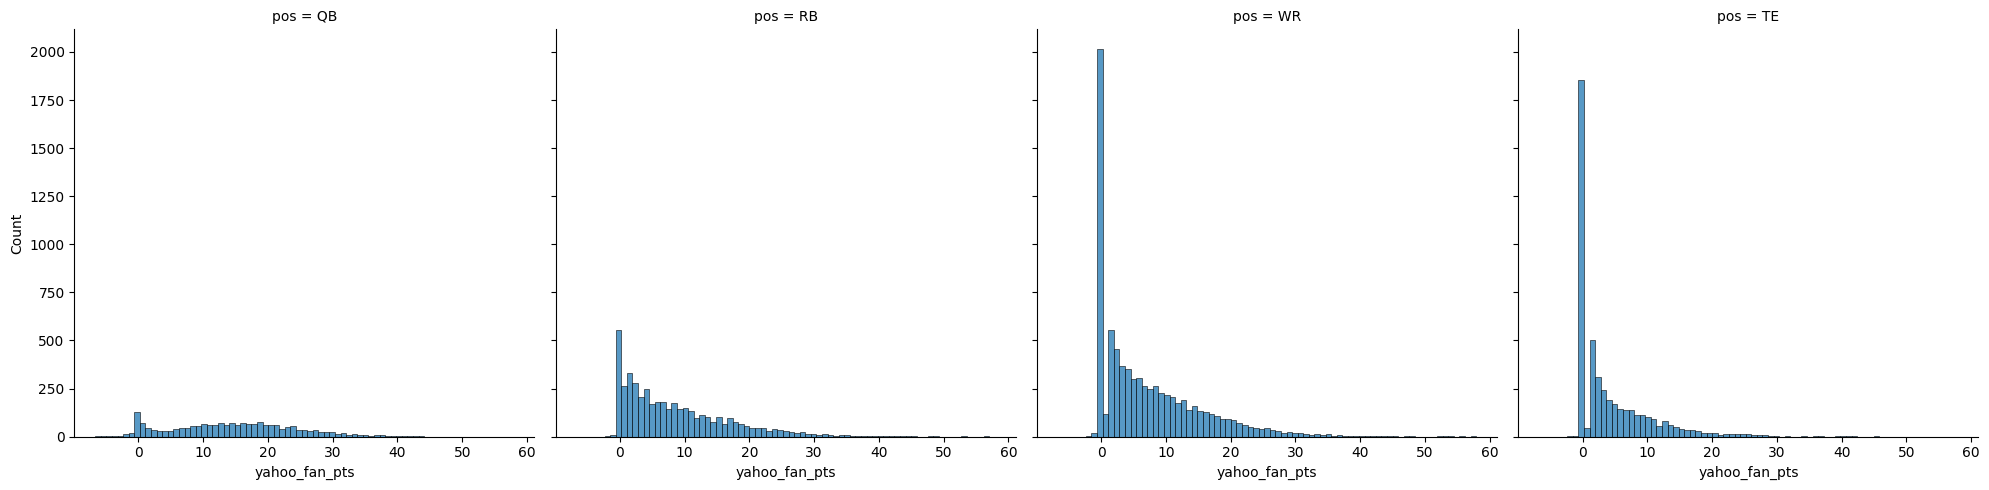

In [5]:
#historgram of QB fantasy points scored
#sns.histplot(data = off_stats[off_stats['pos'] == 'QB'], x = 'yahoo_fan_pts')
#sns.histplot(data = off_stats[off_stats['pos'] == 'WR'], x = 'yahoo_fan_pts')
#sns.histplot(data = off_stats[off_stats['pos'] == 'RB'], x = 'yahoo_fan_pts')
#sns.histplot(data = off_stats[off_stats['pos'] == 'TE'], x = 'yahoo_fan_pts')
sns.displot(data = off_stats[off_stats['pos'].isin(['QB', 'WR', 'RB', 'TE'])], x = 'yahoo_fan_pts', col = 'pos')

Needed a way to see the distribution of fantasy points by player and get a measure for central tendency and variation. `describe` is just the dataframe method from pandas with a histogram graphed as well. I also define a dictionary to store the data about my roster on Yahoo.

Wide Receivers
count    42.000000
mean     15.297619
std       7.171675
min       5.500000
25%       9.125000
50%      14.650000
75%      19.850000
max      30.600000
Name: yahoo_fan_pts, dtype: float64


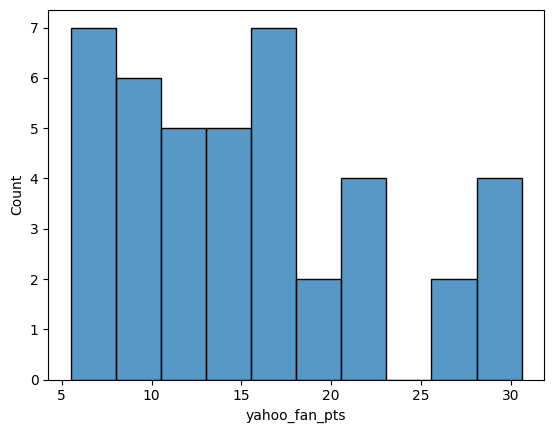

In [6]:
def describe(off_stats, player_name):
    player = off_stats[off_stats['player'] == player_name]
    print(player['yahoo_fan_pts'].describe())
    sns.histplot(data = player, x = 'yahoo_fan_pts', bins = 10)


# below I'm going to try grabbing the data for a player on my fantasy roster - Josh Allen
# After this I will send in a list - my list of fantasy players
fan_roster_dict ={"date": "2022-10-6", "line": ["Josh Allen", "Terry McLaurin","Robert Woods", "Joe Mixon", "Rashaad Penny", "Dalton Schultz", "Gabriel Davis"], "bench": [ "Donovan Peoples-Jones", "Keenan Allen", "Rex Burkhead", "Kenneth Gainwell", "Albert Okwuegbunam", "Matt Ryan"], "defense": "GNB"}
print("Wide Receivers")
describe(off_stats, "Robert Woods")

Here's where things start getting serious. Started out just looking at the overall distribution of fantasy points using box and whisker plots and violin plots. Eventually had the idea to plot them with the wins and losses separate.

#### Analysis

Using the following plots, plotting my starting players for Week 5
- Box and whisker tells us where a majority of data points and range is for categories of interest
- Violin plot tells us the overall distribution of points (notice not too much bimodality but definite right skew - kind of normalish...)

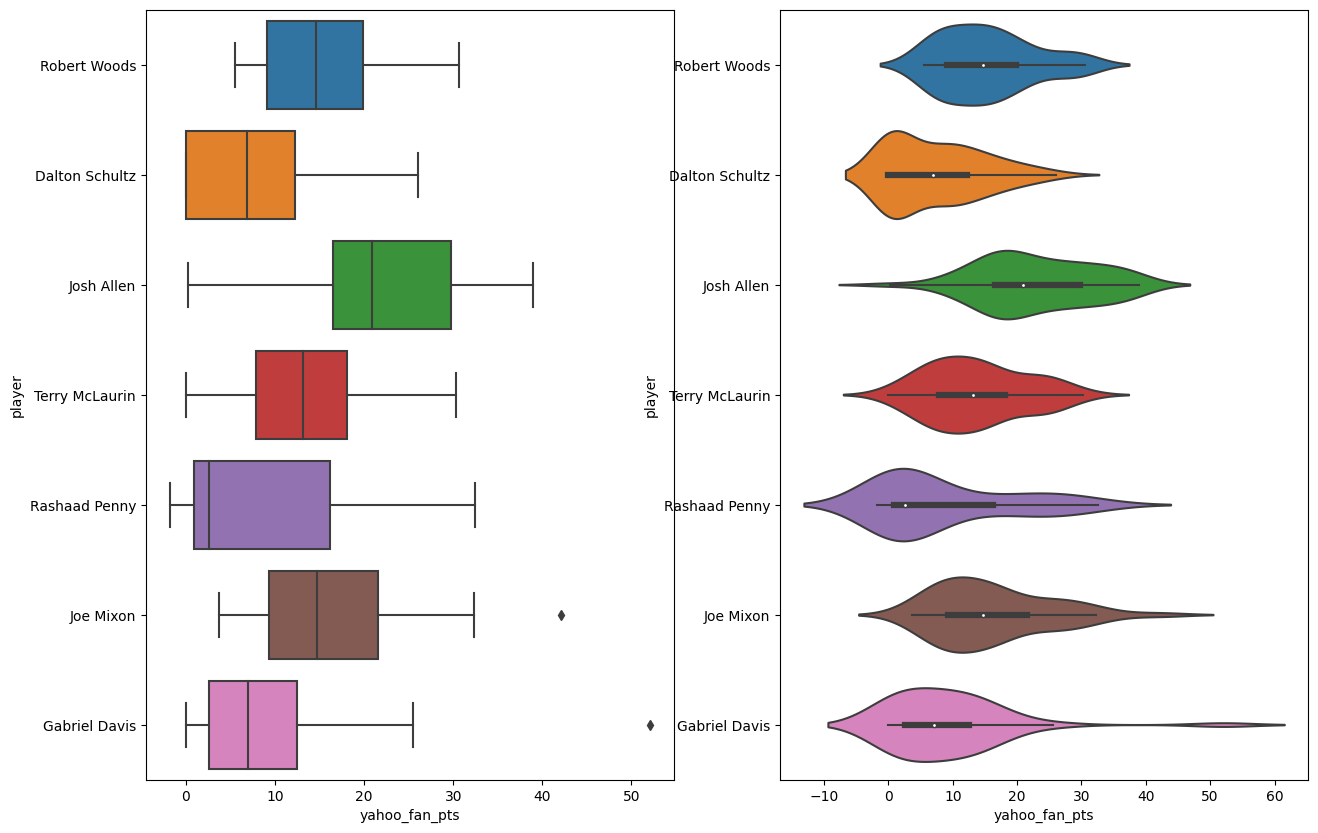

In [14]:
fig = plt.figure(figsize = (15,10 ))
ax = fig.add_subplot(1, 2, 1)
sns.boxplot(data = off_stats[off_stats['player'].isin(fan_roster_dict['line'])],ax = ax, x = 'yahoo_fan_pts', y = 'player')
ax = fig.add_subplot(1, 2, 2)
sns.violinplot(data = off_stats[off_stats['player'].isin(fan_roster_dict['line'])],ax = ax, x = 'yahoo_fan_pts', y = 'player')
plt.show()

Now we break it down by whether the player won or lost

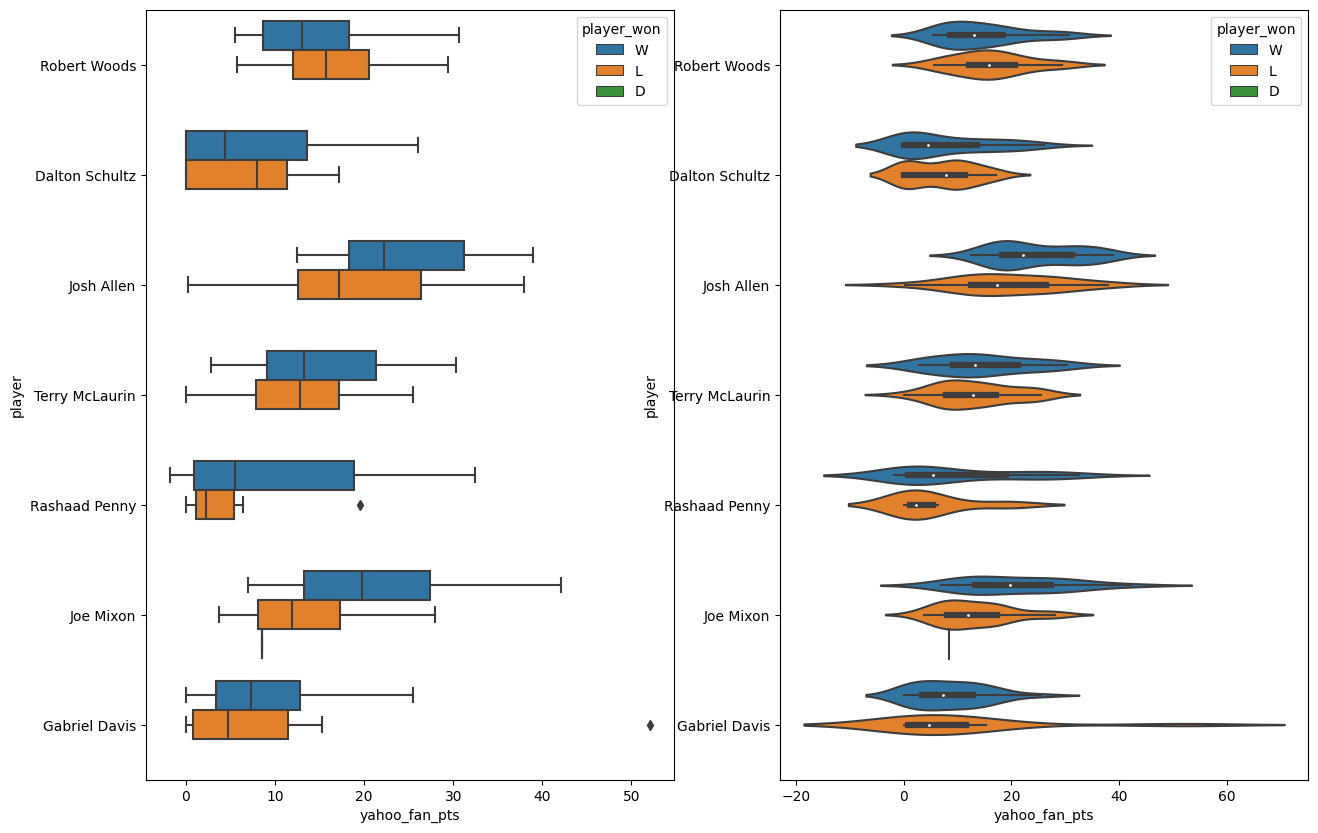

In [13]:
fig = plt.figure(figsize = (15,10 ))
ax = fig.add_subplot(1, 2, 1)
sns.boxplot(data = off_stats[off_stats['player'].isin(fan_roster_dict['line'])],ax = ax, x = 'yahoo_fan_pts', y = 'player', hue = 'player_won')
ax = fig.add_subplot(1, 2, 2)
sns.violinplot(data = off_stats[off_stats['player'].isin(fan_roster_dict['line'])],ax = ax, x = 'yahoo_fan_pts', y = 'player', hue = 'player_won')
plt.show()

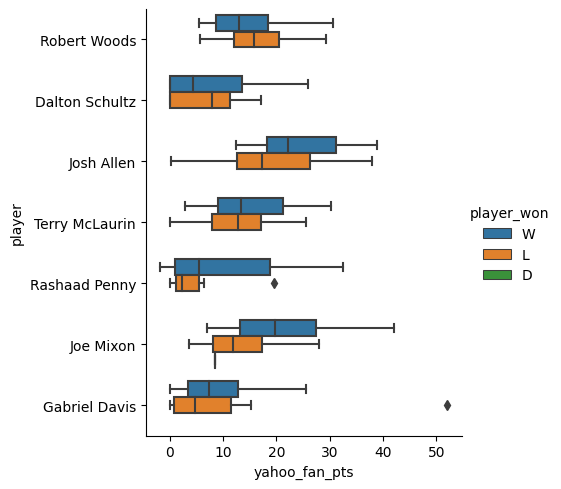

In [6]:
#sns.catplot(data = off_stats[off_stats['player'].isin(fan_roster_dict['line'])], x = 'yahoo_fan_pts', y = 'player')
#sns.violinplot(data = off_stats[off_stats['player'].isin(fan_roster_dict['line'])], x = 'yahoo_fan_pts', y = 'player')
sns.catplot(data = off_stats[off_stats['player'].isin(fan_roster_dict['line'])], x = 'yahoo_fan_pts', y = 'player', hue = 'player_won', kind = 'box')

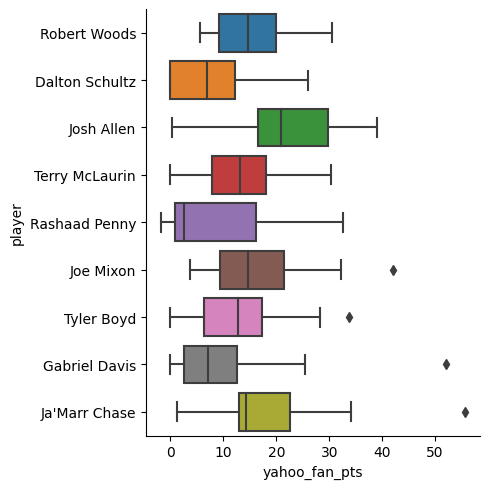

In [32]:
#sns.catplot(data = off_stats[off_stats['player'].isin(fan_roster_dict['bench'])], x = 'yahoo_fan_pts', y = 'player')
#sns.violinplot(data = off_stats[off_stats['player'].isin(fan_roster_dict['bench'])], x = 'yahoo_fan_pts', y = 'player')

# graphs box an whisker plots for all line players and compares to Tyler Boyd and Ja'Marr CHase - this is because I"m up against dylan and we have TYler, Ja'Marr and Joe Mixon all on Cincinatti - in theory I should win, but in practice who knows?
sns.catplot(data = off_stats[np.logical_or(off_stats['player'].isin(fan_roster_dict['line']),off_stats['player'].isin(['Tyler Boyd', "Ja'Marr Chase"]))], x = 'yahoo_fan_pts', y = 'player', kind = 'box')

In [13]:
line_fan_summary = pd.DataFrame()
for player_name in fan_roster_dict['line']:
    next_player = (off_stats[off_stats['player'] == player_name])['yahoo_fan_pts'].describe()
    next_player = next_player.rename(player_name)
    if len(line_fan_summary) == 0:
        line_fan_summary= next_player
    else:
        line_fan_summary = pd.concat([line_fan_summary, next_player], axis = 1) 

print("Line Fantasy Point Summary Statistics")
line_fan_summary

Line Fantasy Point Summary Statistics


,Josh Allen,Terry McLaurin,Robert Woods,Joe Mixon,Rashaad Penny,Dalton Schultz,Gabriel Davis
count,55.000000,47.000000,42.000000,42.000000,23.000000,50.000000,37.000000
mean,22.938545,13.674468,15.297619,16.143810,8.713043,7.456000,9.175676
std,8.811003,7.579190,7.171675,8.806418,10.620876,7.322405,9.691818
min,0.200000,0.000000,5.500000,3.700000,-1.800000,0.000000,0.000000
25%,16.520000,7.900000,9.125000,9.325000,0.900000,0.000000,2.600000
50%,20.940000,13.100000,14.650000,14.700000,2.600000,6.900000,7.000000
75%,29.780000,18.100000,19.850000,21.525000,16.200000,12.225000,12.500000
max,38.920000,30.300000,30.600000,42.100000,32.500000,26.000000,52.100000


# Statistical Analysis


My First crack at doing Welch's *t*-test on a player. This can be used since
1. The wins are statistically independent of losses (not necessarily totally true, but effect is very small I suspect)
1. Wins and Losses are Normally Distributed (kind of...)
1. We don't know if the variance of the population (their true variance) is the same for W's and L's. (if we wanted to assume that, then we could use the *Student* *t*-test instead).

Typically using a 1 tail test here - Wins are generally better than losses for netting points. $p$ values of `.05` or less is what we want to show statistical significants (95% Confidence Interval)

In [7]:
player_to_test = "Joe Mixon"
ttest_ind(off_stats[np.logical_and(off_stats['player'] == player_to_test, off_stats['player_won'] == 'W' )]['yahoo_fan_pts'], off_stats[np.logical_and(off_stats['player'] == player_to_test, off_stats['player_won'] == 'L' )]['yahoo_fan_pts'], equal_var = False)

Ttest_indResult(statistic=2.740840507177392, pvalue=0.01138455575181086)

### By Position

Do the same hypothesis testing on each position. Interestingly, they all seem to indicate that their true means differ, using Student *t*-test. However, its very clear that the Quarterback position is most sensitive by a lot on average to their fantasy performance being affected by whether they win or lose.. However the WR, RB, and TE positions are somewhat cluttered with players who score very little (I haven't looked into it too much yet).

In [48]:
#testing for significants between the fantasy points scored vs position based on whether win-lose or draw
positions = ['QB', 'WR', 'RB', 'TE']
for position in positions:
    print("Position {}: ".format(position),ttest_ind(off_stats[np.logical_and(off_stats['pos'] == position, off_stats['player_won'] == 'W')]['yahoo_fan_pts'], off_stats[np.logical_and(off_stats['pos'] == position, off_stats['player_won'] == 'L')]['yahoo_fan_pts'], alternative = 'greater'))

Position QB:  Ttest_indResult(statistic=8.926588063950842, pvalue=4.8815159658968685e-19)
Position WR:  Ttest_indResult(statistic=2.9800066833110277, pvalue=0.0014456134323359944)
Position RB:  Ttest_indResult(statistic=7.2787408096959325, pvalue=1.9831777022744462e-13)
Position TE:  Ttest_indResult(statistic=3.3811166304943505, pvalue=0.00036390843152955664)


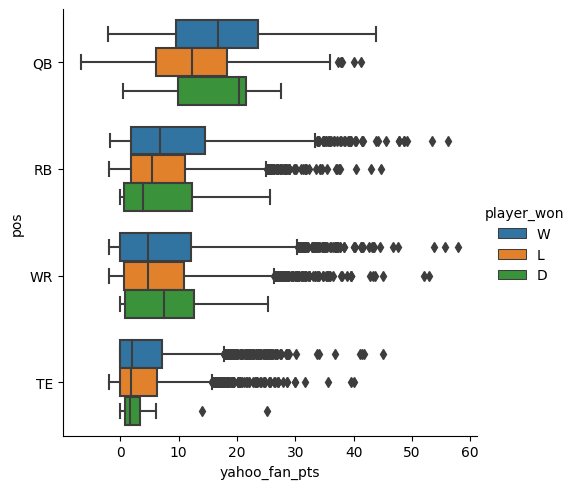

In [31]:

sns.catplot(data = off_stats[off_stats['pos'].isin(positions)], x = 'yahoo_fan_pts', y = 'pos', hue = 'player_won', kind = 'box')

Lastly, its Week 5 in our league and I'm up against Dylan. we're close I'm at 95 points he's at 97 and we both have one game left, I have 2 players on bengals he has 1. Did the analysis of who performs better - Ja'Marr Chase is a better losing player than Joe Mixon on my team. Also in conversation Dylan asked me to check out Derrick Henry - he basically naps if his team is losing... 

For each player I dod the same one tailed Welch's *t*-test, finding that only Tyler Boyd and Ja'Marr Chase do not show a statistically significant difference in their average points scored for W's vs L's. 

Joe Mixon:  Ttest_indResult(statistic=2.740840507177392, pvalue=0.00569227787590543)
Derrick Henry :  Ttest_indResult(statistic=4.470927733572888, pvalue=2.9171609028424666e-05)
Josh Allen:  Ttest_indResult(statistic=1.929747536978701, pvalue=0.03191180206231444)
Tyler Boyd:  Ttest_indResult(statistic=-0.6411795310134012, pvalue=0.7374723389564379)
Ja'Marr Chase:  Ttest_indResult(statistic=1.0985242063641512, pvalue=0.14285098521300826)


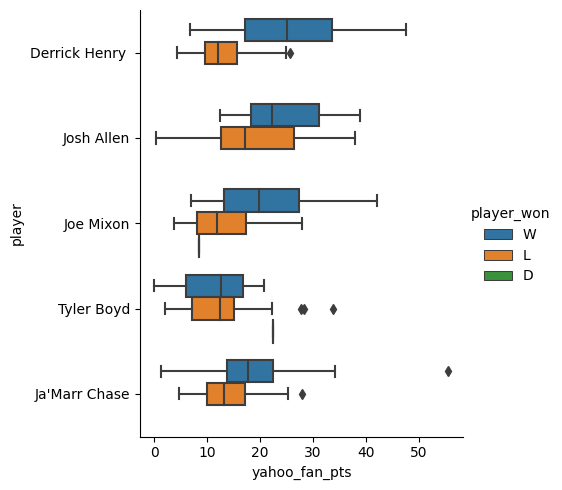

In [8]:
loss_underperformers = ['Joe Mixon', 'Derrick Henry ', 'Josh Allen', 'Tyler Boyd', "Ja'Marr Chase"]
#welch's t-test on underperformers
for player in loss_underperformers:
    print("{}: ".format(player),ttest_ind(off_stats[np.logical_and(off_stats['player'] == player, off_stats['player_won'] == 'W' )]['yahoo_fan_pts'], off_stats[np.logical_and(off_stats['player'] == player, off_stats['player_won'] == 'L' )]['yahoo_fan_pts'], equal_var = False, alternative = 'greater'))

sns.catplot(data = off_stats[off_stats['player'].isin(loss_underperformers)], x = 'yahoo_fan_pts', y = 'player', hue = 'player_won', kind = 'box')



## Planning

### Classes

Eventually I'm going to add classes to help with organization and speed, I at least need
1. Player
1. Fantasy Roster
1. Team

#### Player

1. Data: 
  1. Name
  1. Position
  1. Team
  1. Pandas Dataframe - selecting the year and the player, it shoudl also reduce the dataset columns to just ones relevant to the player position.
    - add column with fantasy points per game
  1. Dictionary with metadata
1. Methods:
  1. Constructor - Accepts player and year and grabs data for the player and which year of data
    1. Initializes returning # columns and # entries
  1. Fantasy Analysis - A method that generates a set of graphs or summary graph suite that give a good indication of the player performance
  1. Hypothesis test win-loss fantasy gain.
  1. Other specific graphs

Grabbing multiple players?

#### Roster

1. Data:
  1. Current Date
  2. line
  3. bench
1. 
  1. Add
  2. Delete player
  3. Send (to bench or to line)

#### Team

1. Data:
1. Methods:

# Log

- Oct 6: brought in all datasets and also created function that takes an off player played games ie. `off_stats` and calculates their fantasy points for that game using a fantasy fules dataset `fan_off_points`.
- Oct 6 - 9: Lots of exploratory work, initial analysis, and statistical analysis
